# Preprocessing - Notebook 3
## Enhancing dataset

- Enhance image quality by applying noise reduction/contrast enhancement
- Resizing images with padding so all images are fixed size (for CNN)



In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import random
import shutil
from collections import Counter

In [11]:
# Seting matplotlib style
plt.style.use('ggplot')

# Paths
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"

trainImagePath = datasetPath / "train" / "images"
trainLabelPath = datasetPath / "train" / "labels"
testImagePath = datasetPath / "test" / "images"
testLabelPath = datasetPath / "test" / "labels"

trainImages = sorted(os.listdir(trainImagePath))
testImages = sorted(os.listdir(testImagePath))

print("Dataset paths set up correctly.")

Dataset paths set up correctly.


In [9]:
def displayEnhancement(imageFolder, enhancementFunction, numSamples=3, functionName="Enhancement"):

    # Get all images in the folder and select random ones
    imageFiles = [f for f in os.listdir(imageFolder) if f.endswith(".jpeg")]
    randomImages = random.sample(imageFiles, numSamples)

    # Set up figure
    fig, axes = plt.subplots(numSamples, 2, figsize=(8, numSamples * 3))

    for i, imgFile in enumerate(randomImages):
        # Load the original image
        imgPath = os.path.join(imageFolder, imgFile)
        img = cv2.imread(imgPath)
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for display

        # Apply the enhancement function
        enhancedImg = enhancementFunction(img)
        enhancedImgRGB = cv2.cvtColor(enhancedImg, cv2.COLOR_BGR2RGB)

        # Plot Original
        axes[i, 0].imshow(imgRGB)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        # Plot Enhanced
        axes[i, 1].imshow(enhancedImgRGB)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"{functionName}")

    plt.tight_layout()
    plt.show()

## Gaussian Blur (Noise Reduction)
Blurs the image to remove noise while preserving edges.


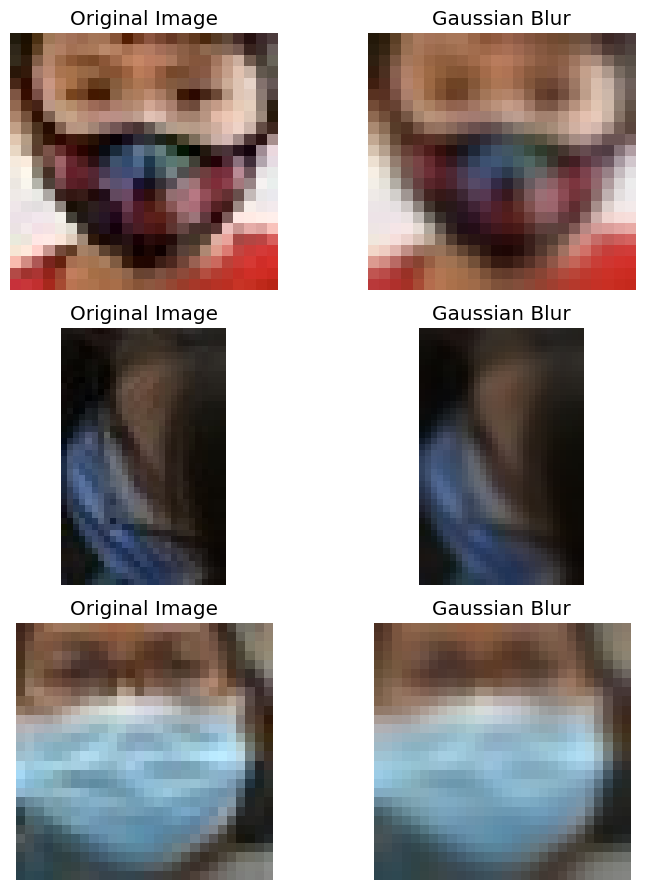

In [18]:
def applyGaussianBlur(img):

    return cv2.GaussianBlur(img, (3, 3), 0)


displayEnhancement(trainImagePath, applyGaussianBlur, numSamples=3, functionName="Gaussian Blur")


## Histogram Equalization (Contrast Enhancement)
Enhances image contrast by adjusting the brightness level


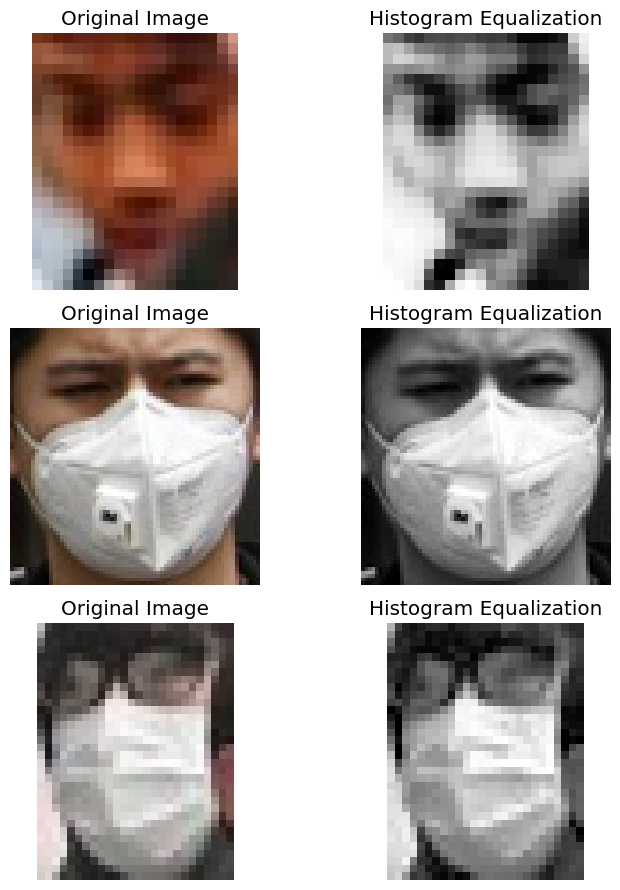

In [9]:
def applyHistogramEqualization(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    equalized = cv2.equalizeHist(gray)  # apply histogram equalization
    return cv2.merge([equalized, equalized, equalized])  # converting back to 3 channel grayscale

displayEnhancement(trainImagePath, applyHistogramEqualization, numSamples=3, functionName="Histogram Equalization")


## Adaptive Histogram Equalization (CLAHE)
Applying localized contrast improvement to prevent image from becoming too bright


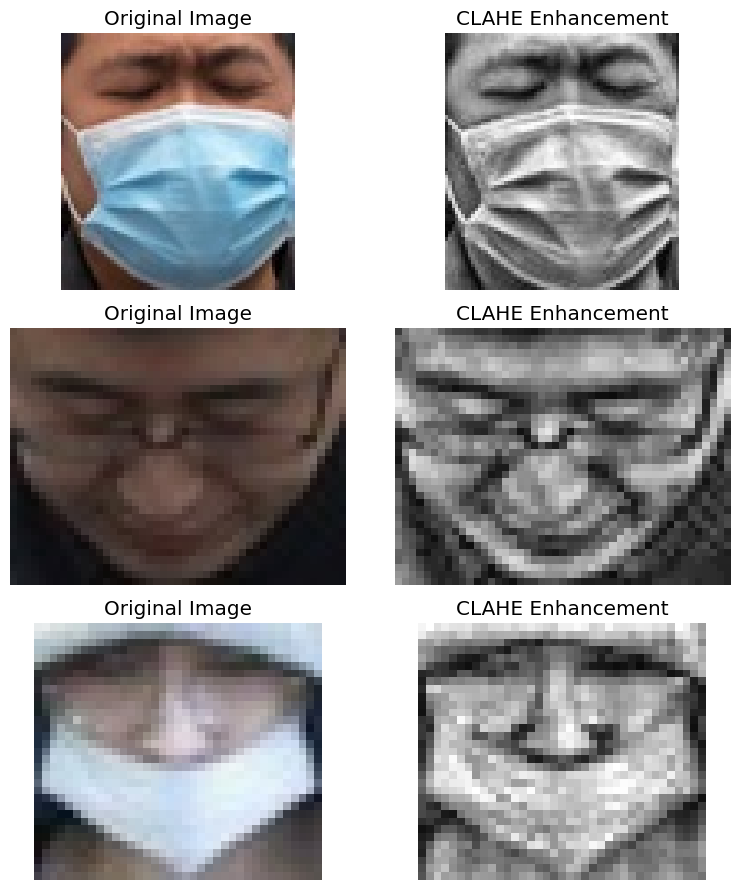

In [21]:
def applyCLAHE(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    return cv2.merge([equalized, equalized, equalized])  #convert back to 3 channel


displayEnhancement(trainImagePath, applyCLAHE, numSamples=3, functionName="CLAHE Enhancement")


## Sharpening Filter
Enhances edges to make details more clear


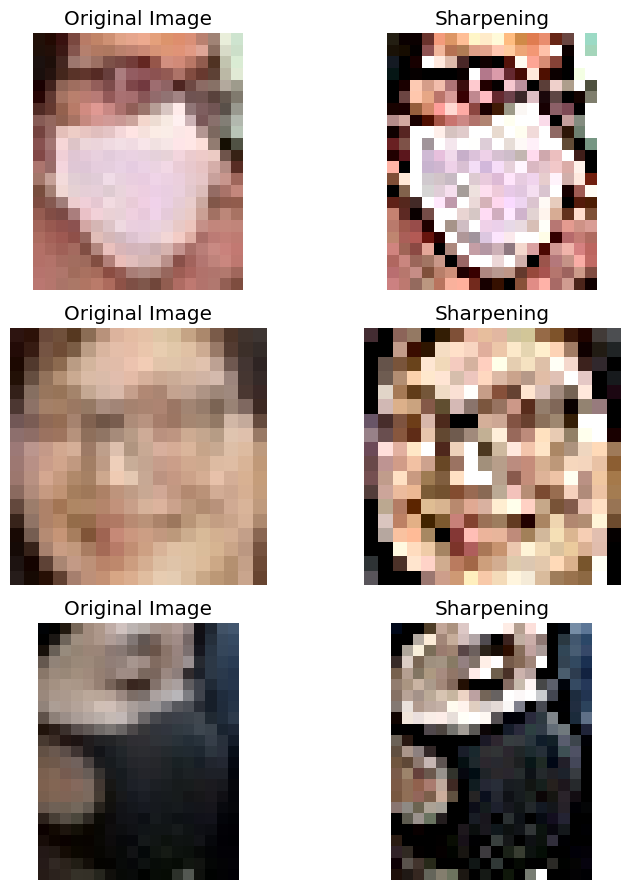

In [22]:
def applySharpening(img):

    sharpeningKernel = np.array([[0, -1, 0], 
                                 [-1, 5, -1], 
                                 [0, -1, 0]])
    return cv2.filter2D(img, -1, sharpeningKernel)

displayEnhancement(trainImagePath, applySharpening, numSamples=3, functionName="Sharpening")


## Edge Detection (Canny)
Detectecting strong edges in the image for future feature extraction


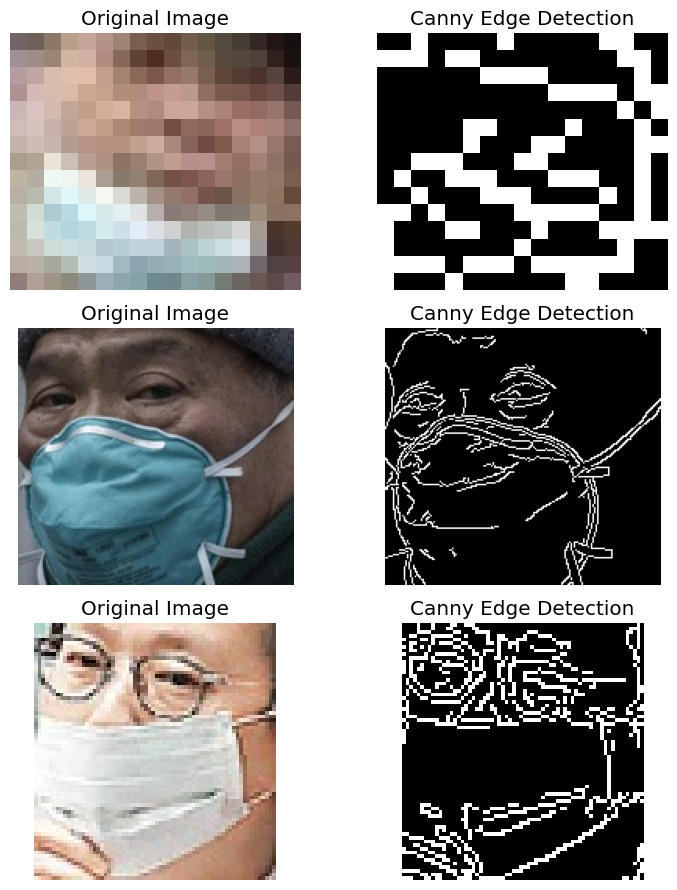

In [23]:
def applyCannyEdgeDetection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)  # apply Canny Edge 
    return cv2.merge([edges, edges, edges])  #convert back to 3 channel

displayEnhancement(trainImagePath, applyCannyEdgeDetection, numSamples=3, functionName="Canny Edge Detection")


In [8]:
def applyMultiEnhancements(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # apply Gaussian Blur
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # apply Sharpening Filter 
    sharpeningKernel = np.array([[0, -1, 0], 
                                 [-1, 5, -1], 
                                 [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, sharpeningKernel)

    # Convert back to 3-channel grayscale
    finalImage = cv2.merge([sharpened, sharpened, sharpened])

    return finalImage

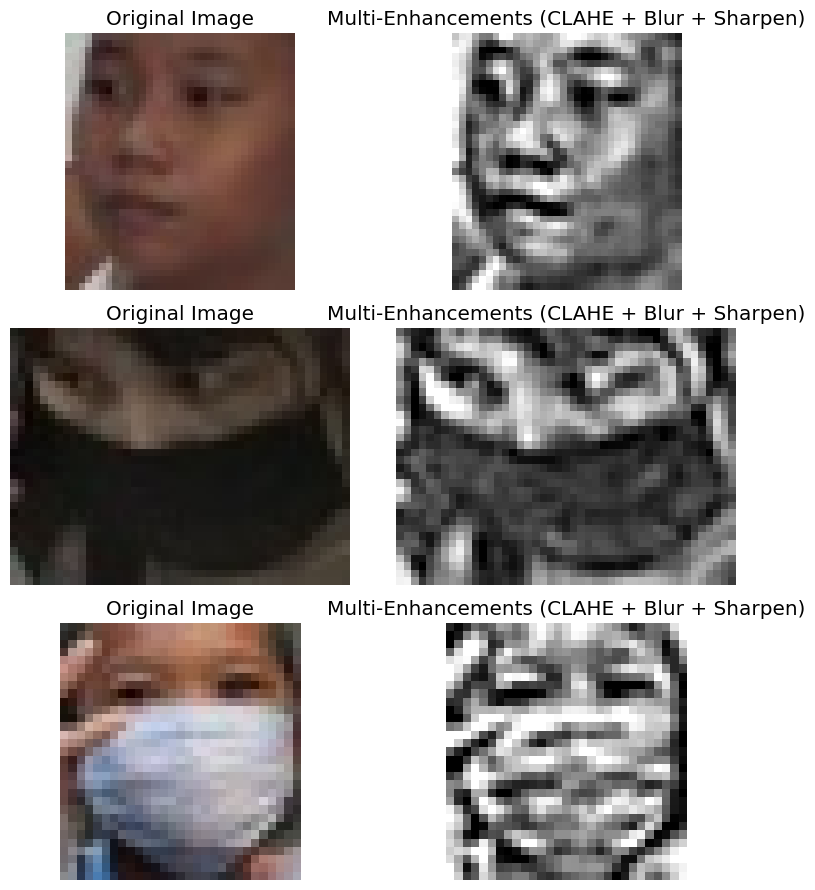

In [6]:
displayEnhancement(trainImagePath, applyMultiEnhancements, numSamples=3, functionName="Multi-Enhancements (CLAHE + Blur + Sharpen)")


In [9]:
# creating output directories
outputRoot = projectRoot / "ModifiedDataset"
trainOutputPath = outputRoot / "train" / "images"
trainOutputLabelPath = outputRoot / "train" / "labels"
testOutputPath = outputRoot / "test" / "images"
testOutputLabelPath = outputRoot / "test" / "labels"

for path in [trainOutputPath, trainOutputLabelPath, testOutputPath, testOutputLabelPath]:
    path.mkdir(parents=True, exist_ok=True)

In [10]:
def resizeWithPadding(img, target_size=(128, 128)):
    # geet current dimensions
    h, w = img.shape[:2]
    
    # calculate target dimensions also preserve aspect ratio
    target_w, target_h = target_size
    
    # Determine which dimension to scale by
    aspect = w / h
    
    if aspect > 1:  # Width > Height landscape
        new_w = target_w
        new_h = int(new_w / aspect)
    else:  # Height >= Width portrait
        new_h = target_h
        new_w = int(new_h * aspect)
    
    # ensure dimensions minimum 1 pixel
    new_w = max(1, new_w)
    new_h = max(1, new_h)
    
    # resize image
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # calculate padding
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left
    
    # apply padding
    if len(img.shape) == 3:  # Color image (BGR)
        color = [0, 0, 0]
    else:  # Grayscale
        color = 0
        
    padded = cv2.copyMakeBorder(
        resized, top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=color
    )
    
    return padded

In [11]:
def processDataset(src_img_path, src_label_path, dst_img_path, dst_label_path):
    #get all image files
    image_files = [f for f in os.listdir(src_img_path) if f.endswith('.jpeg')]
    
    # process each image
    for img_file in tqdm(image_files, desc=f"Processing images from {src_img_path}"):
        # load image
        img_path = os.path.join(src_img_path, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        # apply enhancements from applyMultiEnhancements func
        enhanced = applyMultiEnhancements(img)
        
        #resize with padding
        final_img = resizeWithPadding(enhanced, target_size=(128, 128))
        
        # save enhanced image
        output_path = os.path.join(dst_img_path, img_file)
        cv2.imwrite(output_path, final_img)
        
        # copy corresponding label file
        label_file = img_file.replace('.jpeg', '.txt')
        label_path = os.path.join(src_label_path, label_file)
        
        # Read and write label
        with open(label_path, 'r') as f:
            label_content = f.read()
        
        output_label_path = os.path.join(dst_label_path, label_file)
        with open(output_label_path, 'w') as f:
            f.write(label_content)
    
    print(f"Processed {len(image_files)} images from {src_img_path} to {dst_img_path}")

In [12]:
# process training dataset
processDataset(
    str(trainImagePath),
    str(trainLabelPath),
    str(trainOutputPath),
    str(trainOutputLabelPath)
)

# process test dataset
processDataset(
    str(testImagePath),
    str(testLabelPath),
    str(testOutputPath),
    str(testOutputLabelPath)
)

print("Dataset preprocessing complete!")

Processing images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\train\images: 100%|████████████████████████████████████████████████████████████████████████████████████| 2394/2394 [00:15<00:00, 150.38it/s]


Processed 2394 images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\train\images to C:\3rd year uni\IN1 Computer Vision\MaskDetection\ModifiedDataset\train\images


Processing images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\test\images: 100%|███████████████████████████████████████████████████████████████████████████████████████| 458/458 [00:02<00:00, 155.79it/s]

Processed 458 images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\test\images to C:\3rd year uni\IN1 Computer Vision\MaskDetection\ModifiedDataset\test\images
Dataset preprocessing complete!


In [13]:
# Visualize some examples
def visualizeProcessedImages(original_path, processed_path, num_samples=3):
    """Display original and processed versions of random images"""
    # get all images in the folder and select random ones
    imageFiles = [f for f in os.listdir(original_path) if f.endswith(".jpeg")]
    randomImages = random.sample(imageFiles, num_samples)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
    
    for i, imgFile in enumerate(randomImages):
        # load original image
        original_img_path = os.path.join(original_path, imgFile)
        original_img = cv2.imread(original_img_path)
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # load processed image
        processed_img_path = os.path.join(processed_path, imgFile)
        processed_img = cv2.imread(processed_img_path)
        
        if len(processed_img.shape) == 2:
            processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2RGB)
        else:
            processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
        
        # Plot Original
        axes[i, 0].imshow(original_img_rgb)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"Original ({original_img.shape[1]}x{original_img.shape[0]})")
        
        # Plot Processed
        axes[i, 1].imshow(processed_img_rgb, cmap='gray')
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Processed (128x128)")
        
    plt.tight_layout()
    plt.show()

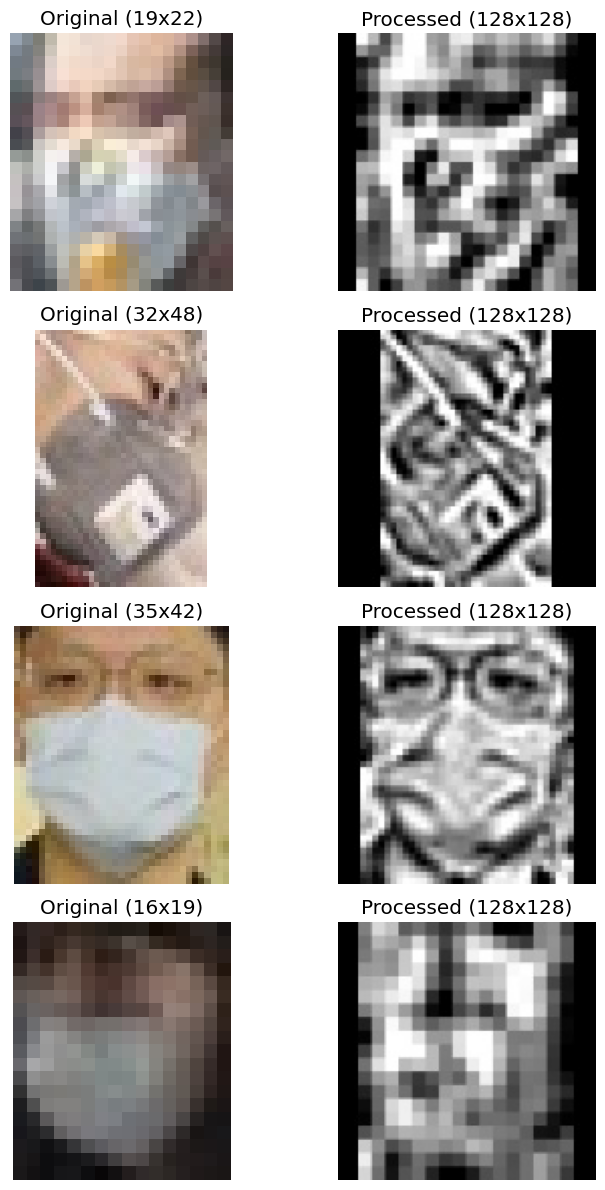

In [14]:
# Visualize some examples
visualizeProcessedImages(str(trainImagePath), str(trainOutputPath), num_samples=4)

CREATING VALIDATION SET

In [13]:
outputRoot = projectRoot / "ModifiedDataset"
trainOutputPath = outputRoot / "train" / "images"
trainOutputLabelPath = outputRoot / "train" / "labels"
testOutputPath = outputRoot / "test" / "images"
testOutputLabelPath = outputRoot / "test" / "labels"
valOutputPath = outputRoot / "validation" / "images"
valOutputLabelPath = outputRoot / "validation" / "labels"

for path in [valOutputPath, valOutputLabelPath]:
    path.mkdir(parents=True, exist_ok=True)

In [16]:
# Stratified split to maintain class distribution
images_by_class = {0: [], 1: [], 2: []}
for img_file in processed_train_images:
    label = get_label(trainOutputLabelPath, img_file)
    images_by_class[label].append(img_file)

# Calculate validation images per class to maintain distribution
val_images = []
for label, images in images_by_class.items():
    # Calculate number of validation images for this class
    n_val = int(len(images) * 0.2)
    
    # Randomly select images for validation
    val_images_for_class = random.sample(images, n_val)
    val_images.extend(val_images_for_class)

In [17]:
validation_label_counter = Counter()
for img_file in val_images:
    # Get label
    label = get_label(trainOutputLabelPath, img_file)
    validation_label_counter[label] += 1
    
    # Move image
    src_img = os.path.join(trainOutputPath, img_file)
    dst_img = os.path.join(valOutputPath, img_file)
    shutil.move(src_img, dst_img)
    
    # Move label file
    label_file = img_file.replace('.jpeg', '.txt')
    src_label = os.path.join(trainOutputLabelPath, label_file)
    dst_label = os.path.join(valOutputLabelPath, label_file)
    shutil.move(src_label, dst_label)

In [19]:
# count remaining training imgs
remaining_train_images = [f for f in os.listdir(trainOutputPath) if f.endswith('.jpeg')]
remaining_label_counter = Counter()
for img_file in remaining_train_images:
    label = get_label(trainOutputLabelPath, img_file)
    remaining_label_counter[label] += 1

# count test imgs by classs
test_counter = Counter()
for img_file in testImages:
    label_file = img_file.replace('.jpeg', '.txt')
    with open(os.path.join(testLabelPath, label_file), 'r') as f:
        test_label = int(f.read().strip())
        test_counter[test_label] += 1

# print final distribution
print("\nFinal dataset splits:")
print(f"Training set: {len(remaining_train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(testImages)} images")

# print class distribution for each dataset
print("\nClass distribution across datasets:")
for label in sorted(remaining_label_counter.keys()):
    train_count = remaining_label_counter[label]
    train_pct = train_count / len(remaining_train_images) if remaining_train_images else 0
    
    val_count = validation_label_counter[label]
    val_pct = val_count / len(val_images) if val_images else 0
    
    test_count = test_counter[label]
    test_pct = test_count / len(testImages) if testImages else 0
    
    print(f"Class {label}:")
    print(f"  Training: {train_count} ({train_pct:.1%})")
    print(f"  Validation: {val_count} ({val_pct:.1%})")
    print(f"  Test: {test_count} ({test_pct:.1%})")






Final dataset splits:
Training set: 1916 images
Validation set: 478 images
Test set: 458 images

Class distribution across datasets:
Class 0:
  Training: 301 (15.7%)
  Validation: 75 (15.7%)
  Test: 51 (11.1%)
Class 1:
  Training: 1552 (81.0%)
  Validation: 388 (81.2%)
  Test: 388 (84.7%)
Class 2:
  Training: 63 (3.3%)
  Validation: 15 (3.1%)
  Test: 19 (4.1%)
